[Link Github for this Project](https://github.com/qviuqh/Paris-temperature-forecasting/)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import warnings
import sys
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error, make_scorer

sys.path.append("..")
from src import utility
from src import preprocessing
from src import features_engineering

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [3]:
# Read the data from the csv file
data = pd.read_csv(r'data\paris_temperature.csv')
data.head(2)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Paris,France",2023-10-01,26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,...,3.5,3,10,2023-10-01T07:49:34,2023-10-01T19:30:27,0.57,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,0715709999..."
1,"Paris,France",2023-10-02,27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,...,4.4,4,10,2023-10-02T07:51:01,2023-10-02T19:28:21,0.60,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0715709999..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              382 non-null    object 
 1   datetime          382 non-null    object 
 2   tempmax           382 non-null    float64
 3   tempmin           382 non-null    float64
 4   temp              382 non-null    float64
 5   feelslikemax      382 non-null    float64
 6   feelslikemin      382 non-null    float64
 7   feelslike         382 non-null    float64
 8   dew               382 non-null    float64
 9   humidity          382 non-null    float64
 10  precip            382 non-null    float64
 11  precipprob        382 non-null    float64
 12  precipcover       382 non-null    float64
 13  preciptype        308 non-null    object 
 14  snow              382 non-null    float64
 15  snowdepth         382 non-null    float64
 16  windgust          382 non-null    float64
 1

# **Features Explanation**

The dataset contains **33 columns (features)** related to weather data in Paris. Below is a detailed explanation of each column, including their meanings and typical values:

### **1. General Information Columns**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `name`           | Location name                                    | `"Paris, France"`             |
| `datetime`       | Date of observation                             | `"2023-10-01"` (YYYY-MM-DD)   |

---

### **2. Temperature-Related Features**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `tempmax`        | Maximum daily temperature (°C)                   | `26.5`                         |
| `tempmin`        | Minimum daily temperature (°C)                   | `12.5`                         |
| `temp`           | Average daily temperature (°C)                   | `18.9`                         |
| `feelslikemax`   | Maximum daily **feels-like** temperature (°C)    | `26.5`                         |
| `feelslikemin`   | Minimum daily **feels-like** temperature (°C)    | `12.5`                         |
| `feelslike`      | Average daily **feels-like** temperature (°C)    | `18.9`                         |

👉 *"Feels-like temperature"* is the temperature perceived by humans, considering humidity and wind.

---

### **3. Humidity & Precipitation Features**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `dew`            | Dew point temperature (°C)                      | `13.7`                         |
| `humidity`       | Relative humidity (%)                           | `74.3`                         |
| `precip`         | Total precipitation (rain/snow) (mm)            | `0.5`                          |
| `precipprob`     | Probability of precipitation (%)                | `30` (means 30% chance of rain) |
| `precipcover`    | Fraction of the day with precipitation (0–1)    | `0.4` (means 40% of the day had precipitation) |
| `preciptype`     | Type of precipitation                           | `"rain"`, `"snow"`, `"none"`   |
| `snow`           | Snowfall (mm)                                   | `0.0` (if no snow)             |
| `snowdepth`      | Snow depth (mm)                                 | `0.0` (if no snow on ground)   |

---

### **4. Wind & Pressure Features**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `windgust`       | Wind gust speed (km/h)                          | `30.2`                         |
| `windspeed`      | Average wind speed (km/h)                       | `12.3`                         |
| `winddir`        | Wind direction (degrees)                        | `180` (south wind)             |
| `sealevelpressure` | Atmospheric pressure at sea level (hPa)      | `1015.2`                        |

---

### **5. Visibility & Cloud Cover Features**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `cloudcover`     | Cloud cover (%)                                 | `60` (60% of sky covered by clouds) |
| `visibility`     | Visibility distance (km)                        | `10` (10 km visibility)        |

---

### **6. Solar & UV Features**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `solarradiation` | Solar radiation (W/m²)                          | `250`                          |
| `solarenergy`    | Solar energy received (MJ/m²)                   | `4.2`                          |
| `uvindex`        | UV Index (intensity of UV radiation)             | `3` (moderate UV level)        |

---

### **7. Additional Risk & Astronomy Features**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `severerisk`     | Risk level for severe weather (0-10)            | `2` (low risk)                 |
| `sunrise`        | Time of sunrise (UTC)                           | `"2023-10-01T07:49:34"`        |
| `sunset`         | Time of sunset (UTC)                            | `"2023-10-01T19:30:27"`        |
| `moonphase`      | **Moon phase (0 to 1)**                         | `0.57`                         |

#### **🔹 What is `moonphase`?**
- `moonphase` represents the phase of the moon **as a fraction between 0 and 1**:
  - `0.00` = New Moon 🌑
  - `0.25` = First Quarter 🌓
  - `0.50` = Full Moon 🌕
  - `0.75` = Last Quarter 🌗
  - `1.00` = New Moon (cycle repeats)

---

### **8. Weather Descriptions**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `conditions`     | General weather conditions                      | `"Rain, Partially cloudy"`     |
| `description`    | More detailed weather description                | `"Partly cloudy throughout the day with morning rain."` |
| `icon`          | Icon representing weather                        | `"rain"`, `"clear-day"`, `"snow"` |

---

### **9. Station Data**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `stations`       | Weather stations used for this data point        | `"07149099999, 07156099999"`  |

---

### **Summary**
- The dataset contains **weather measurements, precipitation, wind, solar data, and astronomical info**.
- The `moonphase` feature **ranges from 0 to 1**, indicating different moon phases.
- Other features like `temp`, `humidity`, and `windspeed` provide essential weather insights.

# **Exploratory Data Analyst**

In [5]:
# Check the duplicate data
d = data.shape[0] - data.duplicated().shape[0]
print(f'The number of duplicate data: {d}')

The number of duplicate data: 0


Number of columns with NaN values: 2


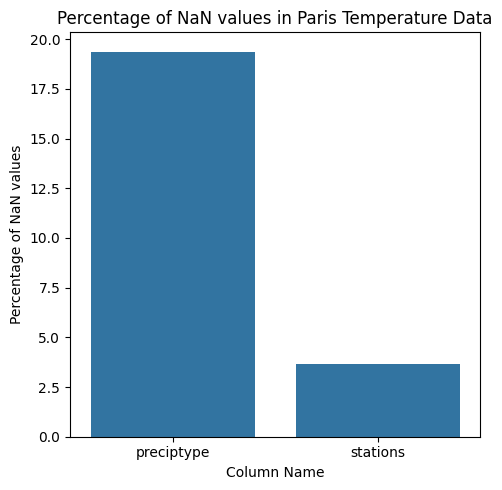

In [6]:
# Run missing value analysis
df_nan = utility.nan_df_create(data)
utility.plot_nan_percent(df_nan, "Paris Temperature Data", figsize=(5, 5), rotation=0)

In [7]:
# Identify numerical and categorical features
numerical_features = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = data.drop(columns=["datetime","name","sunrise","sunset"]).select_dtypes(include=["object"]).columns.tolist()

### Numberical Features

In [8]:
data[numerical_features].describe()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,...,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,16.802356,10.096859,13.279319,16.541623,8.974869,12.624346,8.784293,76.118586,2.053552,71.432461,...,18.495550,209.079843,1013.928796,79.876178,19.180628,49.813874,4.296335,2.913613,10.746073,0.481990
std,6.840083,5.057506,5.819955,7.388110,6.197290,6.674208,4.779705,10.214621,3.939574,44.425978,...,6.069653,87.970190,10.349025,19.049478,4.334291,37.130885,3.214728,2.267046,5.473000,0.289633
min,-1.300000,-4.100000,-1.800000,-5.500000,-7.300000,-6.300000,-6.100000,51.600000,0.000000,0.000000,...,6.800000,0.400000,979.700000,13.000000,5.100000,0.000000,0.000000,0.000000,10.000000,0.000000
25%,11.800000,6.625000,9.300000,11.800000,4.600000,8.025000,6.200000,68.600000,0.000000,0.000000,...,13.900000,180.750000,1008.900000,71.200000,16.800000,16.825000,1.400000,1.000000,10.000000,0.242500
50%,16.150000,10.200000,13.050000,16.150000,10.200000,13.050000,9.150000,76.750000,0.195000,100.000000,...,17.850000,222.000000,1014.650000,85.600000,20.300000,43.500000,3.800000,2.000000,10.000000,0.480000
75%,21.850000,13.600000,17.575000,21.850000,13.600000,17.575000,12.175000,84.475000,2.143000,100.000000,...,21.975000,265.675000,1019.900000,94.075000,22.100000,76.325000,6.500000,4.000000,10.000000,0.750000
max,36.200000,21.200000,28.300000,39.000000,21.200000,29.600000,20.300000,95.000000,25.008000,100.000000,...,44.300000,358.200000,1042.800000,100.000000,39.100000,169.800000,14.700000,8.000000,75.000000,0.980000


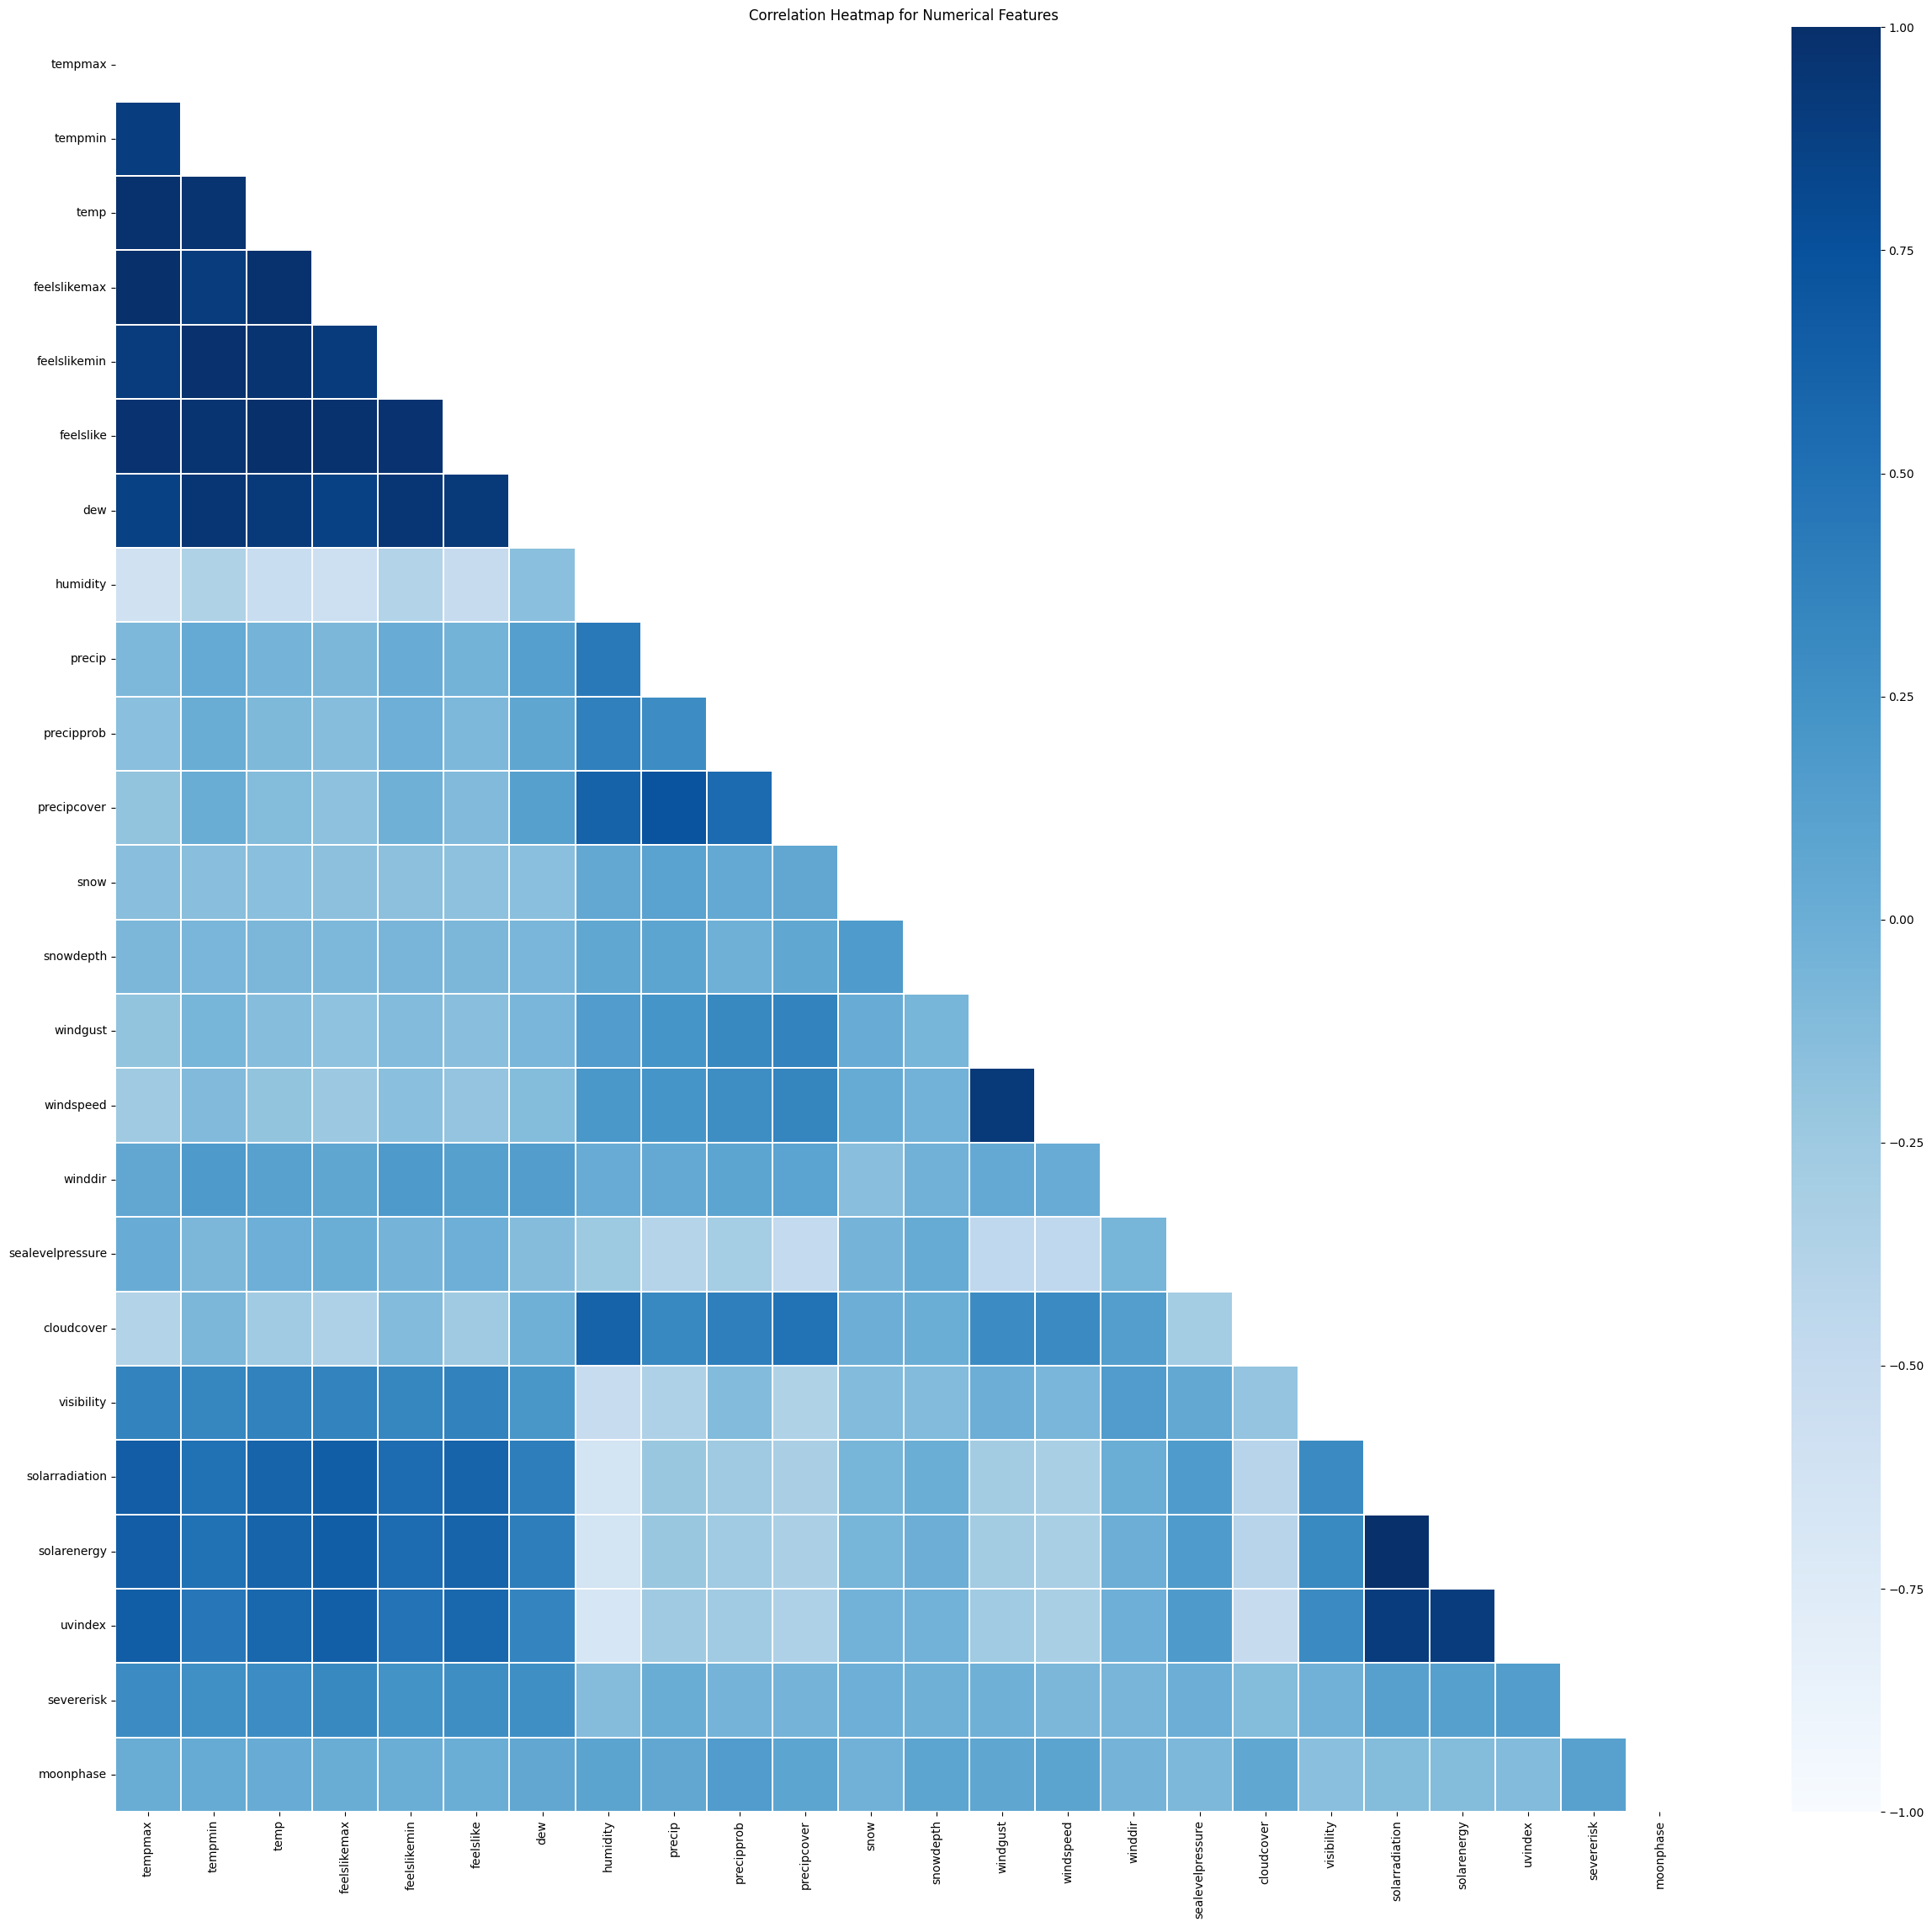

In [9]:
# Run correlation matrix
corr_matrix = utility.correlation_matrix(data, columns_to_drop=["datetime"])
corr_matrix.plot_correlation_matrix()

- Strong correlations:
    + Temperature (temp) has a high correlation with tempmax and tempmin → This makes sense as they all represent daily temperature variations.
    + Dew point (dew) is strongly correlated with humidity (0.86) → Dew point reflects the moisture content in the air.
    + Visibility has a negative correlation with cloud cover (-0.75) → More clouds reduce visibility.
    + Windspeed and wind gust have a strong correlation (0.89) → Wind gusts are closely related to average wind speed.
- Weak or unclear correlations:
    + Some variables, such as sealevelpressure (sea level pressure), have low correlation with temperature and precipitation.
    + Precipitation (precip) has a weak correlation (0.19) with temperature → Precipitation is influenced by multiple factors like pressure, humidity, and wind.


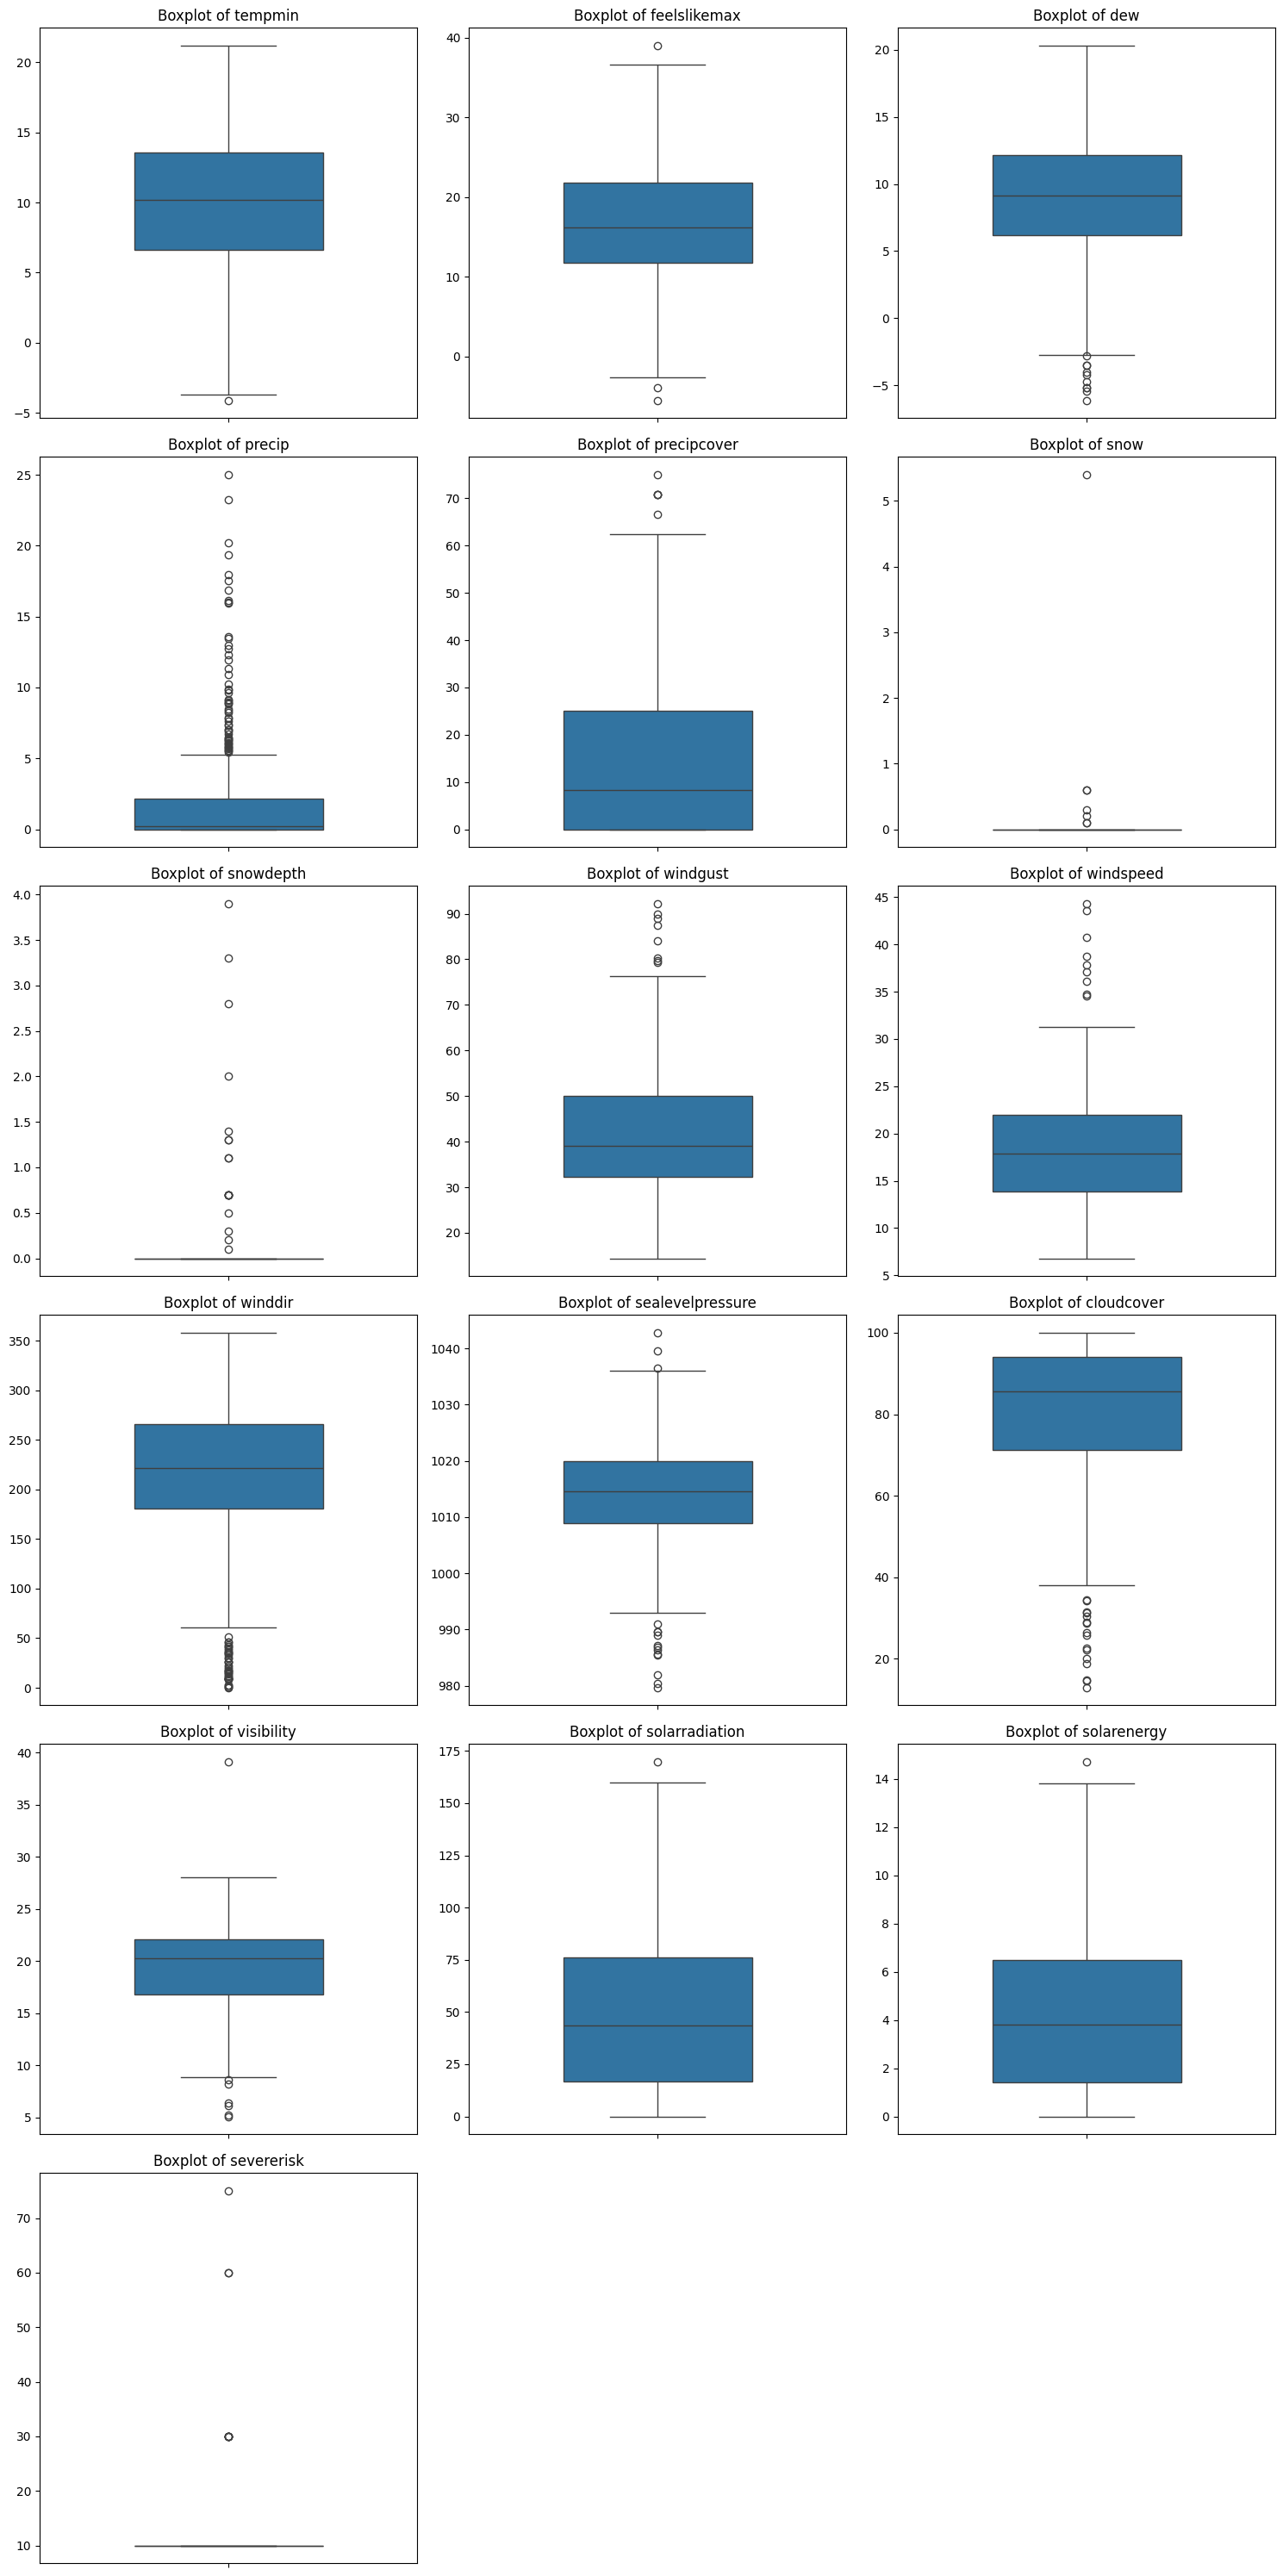

In [10]:
# Run outlier detection
utility.plot_outlier_boxplots(data, numerical_features)

The variables with the most outliers: precip, precipcover, snow, snowdepth, windgust, sealevelpressure, visibility, solarradiation.

### Categorical Features

In [11]:
cate_df = data[['preciptype','conditions','description','icon']]

In [12]:
cate_df

,preciptype,conditions,description,icon
0,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain
1,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
2,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain
3,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain
4,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain
...,...,...,...,...
377,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain
378,rain,Overcast,Cloudy skies throughout the day.,cloudy
379,rain,Overcast,Cloudy skies throughout the day.,cloudy
380,rain,Overcast,Cloudy skies throughout the day.,cloudy


In [13]:
cate_df[cate_df.isnull().any(axis=1)]

,preciptype,conditions,description,icon
1,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
6,NaN,Clear,Clear conditions throughout the day.,clear-day
8,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
9,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
15,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
...,...,...,...,...
345,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
353,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
364,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
369,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


In [14]:
data["preciptype"].value_counts()

preciptype
rain                      301
rain,snow                   6
rain,freezingrain,snow      1
Name: count, dtype: int64

In [15]:
data[categorical_features].describe()

,preciptype,conditions,description,icon,stations
count,308,382,382,382,368
unique,3,8,31,5,27
top,rain,"Rain, Partially cloudy",Partly cloudy throughout the day.,rain,"07149099999,07156099999,07146099999,0715709999..."
freq,301,136,81,269,247


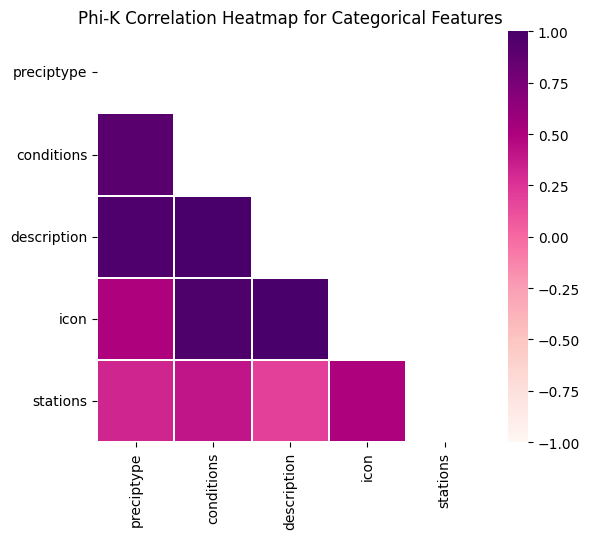

In [16]:
# Run Phi-K correlation analysis
utility.plot_phik_matrix(data, categorical_columns=categorical_features, figsize=(6, 5.5), cmap="RdPu")

- Weather conditions have a strong correlation (0.95) with weather descriptions → This is expected, as descriptions reflect the main weather conditions.
- Precipitation type (preciptype) is highly correlated (0.88) with weather conditions → If the condition is rain or snow, the corresponding precipitation type can be determined.
- Weather icon is correlated (0.91) with conditions and descriptions → The - weather icon accurately represents overall weather conditions.
- Stations have low correlation (0.12) with other variables → This may be due to each weather station collecting independent data, with little direct impact on weather descriptions.


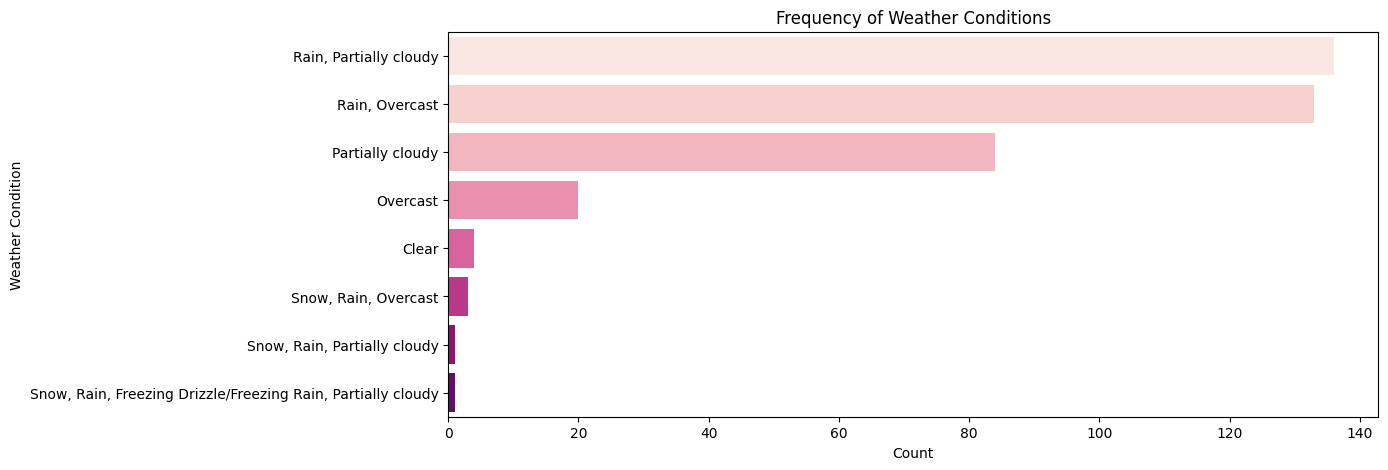

In [17]:
# Categorical Feature Analysis
plt.figure(figsize=(12, 5))
sns.countplot(y=data["conditions"], order=data["conditions"].value_counts().index, palette="RdPu")
plt.title("Frequency of Weather Conditions")
plt.xlabel("Count")
plt.ylabel("Weather Condition")
plt.show()

- Most common weather conditions:
    + "Rain, Partially cloudy" (136 occurrences) and "Rain, Overcast" (133 occurrences).
    + "Partially cloudy" appeared 84 times.
- Rare weather conditions:
    + "Clear" occurred only 4 times.
    + Snow-related conditions like "Snow, Rain, Overcast" appeared just 3 times.


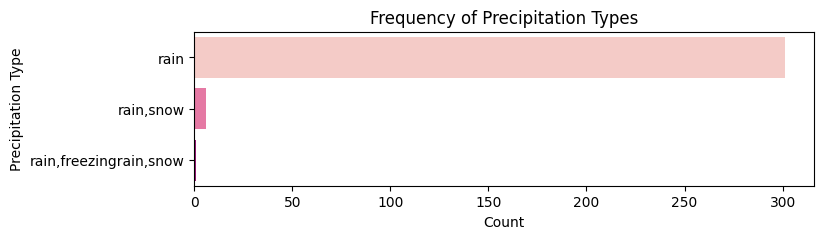

In [18]:
plt.figure(figsize=(8, 2))
sns.countplot(y=data["preciptype"], order=data["preciptype"].value_counts().index, palette="RdPu")
plt.title("Frequency of Precipitation Types")
plt.xlabel("Count")
plt.ylabel("Precipitation Type")
plt.show()

- Rain dominates with about 300 occurrences.
- "Rain, snow" was recorded only 6 times.
- "Rain, freezing rain, snow" appeared just once.

# **Stationality**

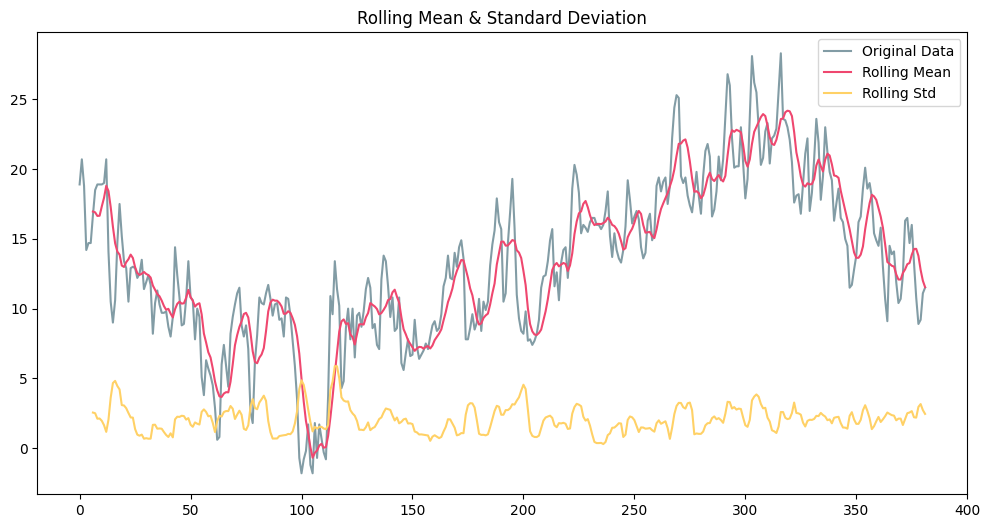

ADF Statistic: -2.74262288763004
p-value: 0.06694856335880939
Critical Values: {'1%': -3.4477686860685, '5%': -2.869216670067509, '10%': -2.570859500573892}
⚠️ Data is not stationary (needs to be processed before forecasting).


In [69]:
utility.check_stationary(data["temp"])

In [70]:
stationary_series, num_diffs, final_adf_results = utility.make_stationary(data['temp'])

print(f"Number of differences: {num_diffs}")
print("-" * 50)
for k, v in final_adf_results.items():
    print(f"{k}: {v}")

Number of differences: 1
--------------------------------------------------
ADF Statistic: -14.794239815296415
p-value: 2.147810770410271e-27
Critical Values: {'1%': -3.4477686860685, '5%': -2.869216670067509, '10%': -2.570859500573892}


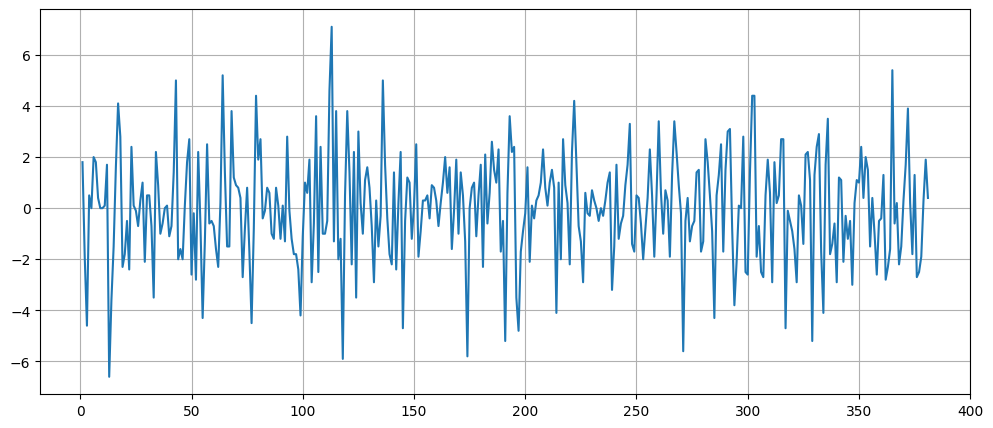

In [71]:
# Plot stationary series over time
plt.figure(figsize=(12, 5))
plt.plot(stationary_series, linestyle='-')
plt.grid(True)
plt.show()

# **Data Preprocessing**

In [19]:
# Convert datetime column to proper datetime format
data['datetime'] = pd.to_datetime(data['datetime'])
data['sunrise'] = pd.to_datetime(data['sunrise'])
data['sunset'] = pd.to_datetime(data['sunset'])

# Sort dataset by datetime
data = data.sort_values(by='datetime')

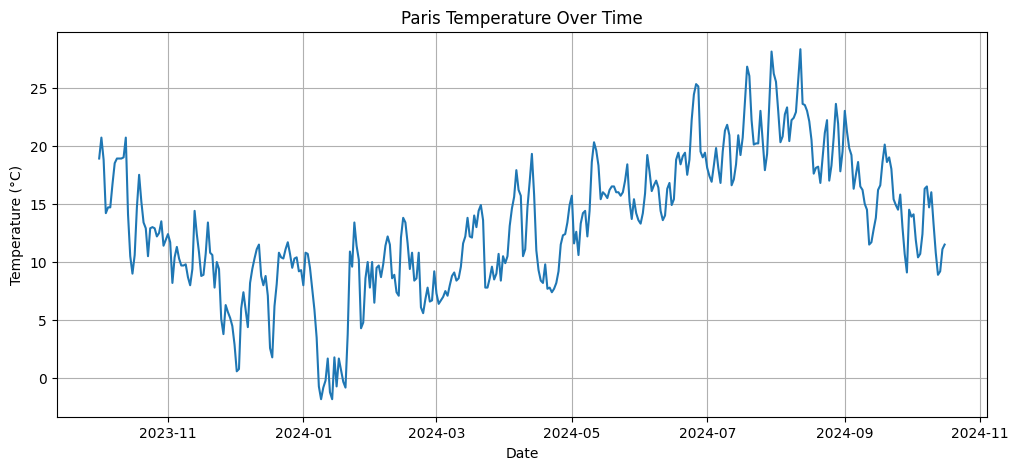

In [20]:
# Plot Paris temperature over time
plt.figure(figsize=(12, 5))
plt.plot(data["datetime"], data["temp"], linestyle='-')
plt.title("Paris Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

- The temperature in Paris ranges from -1.8°C to 28.3°C.
- Seasonal temperature trends:
    + Winter (Dec 2023 - Jan 2024): Temperature drops sharply, with a minimum of -1.8°C.
    + Spring (Mar - May 2024): The average temperature fluctuates between 9.3°C and 17.6°C.
    + Summer (Jun - Aug 2024): The highest recorded temperature reaches 36.2°C.
    + Autumn (Sep - Nov 2024): Temperature gradually decreases, averaging around 13.3°C.
- Temperature fluctuates significantly daily, with a standard deviation of approximately 5.82°C.

In [21]:
# Drop columns with only one unique value
columns_to_drop = [col for col in data.columns if data[col].nunique() == 1]
data = data.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")

Dropped columns: ['name']


In [22]:
# Delete columns
data = data.drop(columns=["stations","description","icon",])

### **1. Handling Missing Values**

In [23]:
# Fill null values in "preciptype" with seperator "dry"
data = preprocessing.fill_null_values(data,"preciptype","dry")

### **2. Split Train-Test**

In [24]:
data.to_csv(r"data\data.csv", index=False)

In [25]:
data[data["datetime"] == "2024-09-15"].index

Index([350], dtype='int64')

Train set: 351 rows, from 0 to 350
Test set: 31 rows, from 351 to 381


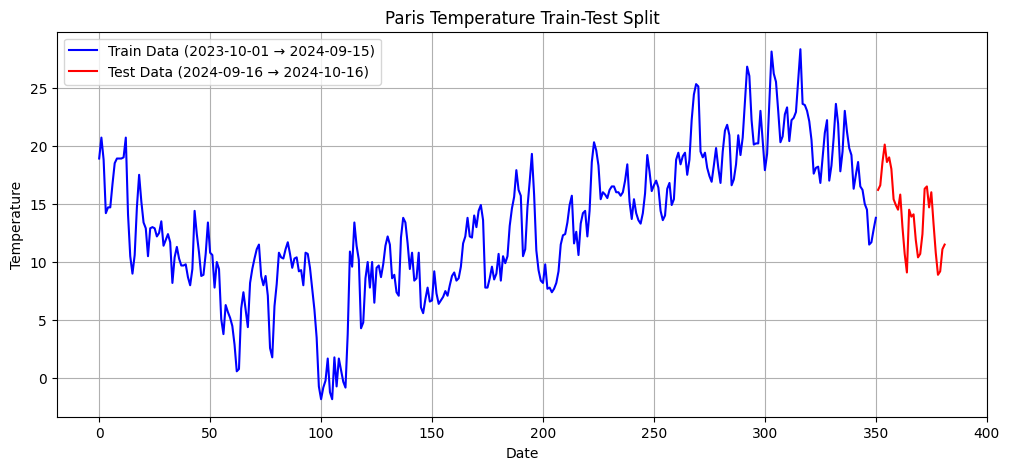

In [ ]:
# Train-Test Split
train = data.loc[:350]
test = data.loc[351:]

# Print data sizes
print(f"Train set: {train.shape[0]} rows, from {train.index.min()} to {train.index.max()}")
print(f"Test set: {test.shape[0]} rows, from {test.index.min()} to {test.index.max()}")

# Plot train & test split
plt.figure(figsize=(12,5))
plt.plot(train["temp"], label="Train Data (2023-10-01 → 2024-09-15)", color="blue")
plt.plot(test["temp"], label="Test Data (2024-09-16 → 2024-10-16)", color="red")
plt.legend()
plt.title("Paris Temperature Train-Test Split")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.grid(True)
plt.show()

In [27]:
train.to_csv(r"data\train.csv", index=False)
test.to_csv(r"data\test.csv", index=False)

### **3. Handling Outliers**

In [80]:
# Replace outliers using IQR method (capping).
# Replace outliers and Check for outliers before/after
lowers = {}
uppers = {}

print("#"*20 + "   TRAIN_DATA   " + "#"*20)
print("Before:", preprocessing.count_outliers(train, numerical_features))
train = preprocessing.replace_outliers(train, numerical_features, lowers, uppers, train=True)
print("After:", preprocessing.count_outliers(train, numerical_features))

print("#"*20 + "   TEST_DATA   " + "#"*21)
print("Before:", preprocessing.count_outliers(test, numerical_features))
test = preprocessing.replace_outliers(test, numerical_features, lowers, uppers)
print("After:", preprocessing.count_outliers(test, numerical_features))

####################   TRAIN_DATA   ####################
Before: {'tempmax': 0, 'tempmin': 2, 'temp': 0, 'feelslikemax': 2, 'feelslikemin': 0, 'feelslike': 0, 'dew': 9, 'humidity': 0, 'precip': 52, 'precipprob': 0, 'precipcover': 5, 'snow': 7, 'snowdepth': 18, 'windgust': 6, 'windspeed': 7, 'winddir': 34, 'sealevelpressure': 19, 'cloudcover': 15, 'visibility': 9, 'solarradiation': 0, 'solarenergy': 0, 'uvindex': 0, 'severerisk': 9, 'moonphase': 0}
After: {'tempmax': 0, 'tempmin': 0, 'temp': 0, 'feelslikemax': 0, 'feelslikemin': 0, 'feelslike': 0, 'dew': 0, 'humidity': 0, 'precip': 0, 'precipprob': 0, 'precipcover': 0, 'snow': 0, 'snowdepth': 0, 'windgust': 0, 'windspeed': 0, 'winddir': 0, 'sealevelpressure': 0, 'cloudcover': 0, 'visibility': 0, 'solarradiation': 0, 'solarenergy': 0, 'uvindex': 0, 'severerisk': 0, 'moonphase': 0}
####################   TEST_DATA   #####################
Before: {'tempmax': 0, 'tempmin': 0, 'temp': 0, 'feelslikemax': 0, 'feelslikemin': 0, 'feelslike': 0, 

### **4. Prophet Model**

In [81]:
# Prepare train data for Prophet
train_prophet = train.reset_index().rename(columns={"datetime": "ds", "temp": "y"})

# Initialize & fit Prophet model
model = Prophet(yearly_seasonality=True)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(train_prophet)

00:29:47 - cmdstanpy - INFO - Chain [1] start processing
00:29:47 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
# Create future dataframe
future = model.make_future_dataframe(periods=len(test), freq='D', include_history=False)
# Predict
forecast = model.predict(future)
# Extract predicted values
forecast = forecast[["ds", "yhat"]].set_index("ds")

In [83]:
print(forecast.head(10))

                 yhat
ds                   
2024-09-16  11.809755
2024-09-17  11.707925
2024-09-18  11.788021
2024-09-19  11.897014
2024-09-20  11.262017
2024-09-21  10.224002
2024-09-22  10.274612
2024-09-23  10.993590
2024-09-24  11.187376
2024-09-25  11.311728


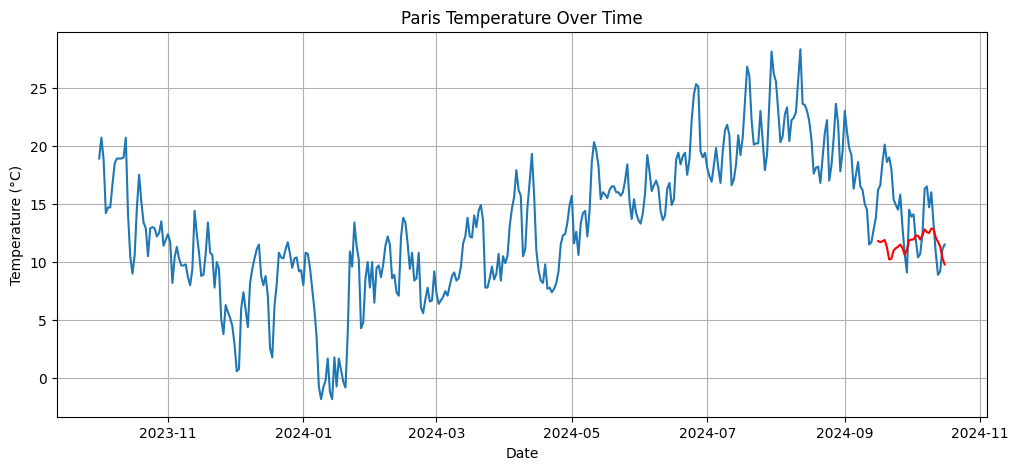

In [84]:
# Plot Paris temperature over time
plt.figure(figsize=(12, 5))
plt.plot(data["datetime"], data["temp"], linestyle='-',label="Actual")
plt.plot(forecast.index, forecast, linestyle='-',color="red", label="Predicted")
plt.title("Paris Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

In [85]:
# Align test & forecast data
test_forecast = forecast.loc[test["datetime"]]

# Compute Metrics
mse = mean_squared_error(test["temp"], test_forecast.values)
rmse = np.sqrt(mse)
r2 = r2_score(test["temp"], test_forecast)
mape = mean_absolute_percentage_error(test["temp"], test_forecast)
mae = mean_absolute_error(test["temp"], test_forecast)

# Print results
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")
print(f"MAPE: {mape:.2%}")
print(f"MAE: {mae:.2f}")

RMSE: 4.00
R² Score: -0.681
MAPE: 21.10%
MAE: 3.22


### *Conclusion from the Results*  

*RMSE = 4.00* → The average error between the forecast and the actual value is about 4°C.

*\( R^2 = -0.681 \)* → Prophet has not modeled the data trend well, the forecast does not match the reality.  

*MAPE = 21.10%* → The average percentage error is quite high, meaning that the forecast has a significant deviation from reality.

### *Possible problems in the Prophet model*
**1. Not capturing short-term fluctuations**

Prophet is a long-term trend-oriented model, suitable for data with cycles or stable trends.

Temperature data can have many unusual fluctuations due to sudden weather changes, which Prophet may not be able to forecast well.

**2. Insufficient input data for accurate forecasting**

Prophet relies solely on historical temperature data, but actual temperatures can be affected by humidity, precipitation, air pressure, and many other factors.

Without additional variables, Prophet may have difficulty forecasting in volatile conditions.

**3. The forecast period has many unusual changes**

If the test set has many strong fluctuations or is in a transitional period, Prophet may not predict well because it relies mainly on the general trend.

Prophet works well when there is a clear cyclical pattern, but if there is an unexpected event such as an unusual cold or hot spell, it will not be able to forecast accurately.

# **Feature Engineering**

In [86]:
train.index = train["datetime"]
train = train.drop(columns=["datetime"])

In [87]:
train_data = train.copy()
features_engineering.create_specific_features(train_data)
remove_cols = train_data.columns
numerical_col = train_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
train_data = features_engineering.create_lag_features(train_data, lag=7, columns=numerical_col)
train_data = features_engineering.create_rolling_features(train_data, window=7, columns=numerical_col)
train_data = features_engineering.create_rolling_features(train_data, window=14, columns=numerical_col)
train_data = features_engineering.create_rolling_features(train_data, window=30, columns=numerical_col)

In [88]:
y_train = train_data["temp"]
X_train = train_data.drop(columns=remove_cols)

In [89]:
X_train.to_csv(r"data\X_train.csv", index=False)
y_train.to_csv(r"data\y_train.csv", index=False)

In [90]:
test.index = test["datetime"]
test = test.drop(columns=["datetime"])

In [91]:
test_data = test.copy()
features_engineering.create_specific_features(test_data)
numerical_col = test_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
test_data = features_engineering.create_lag_features(test_data, lag=7, columns=numerical_col)
test_data = features_engineering.create_rolling_features(test_data, window=7, columns=numerical_col)
test_data = features_engineering.create_rolling_features(test_data, window=14, columns=numerical_col)
test_data = features_engineering.create_rolling_features(test_data, window=30, columns=numerical_col)

In [92]:
y_test = test_data["temp"]
X_test = test_data.drop(columns=remove_cols)

In [93]:
X_test.to_csv(r"data\X_test.csv", index=False)
y_test.to_csv(r"data\y_test.csv", index=False)

# **Feature Selection**

In [94]:
X_train = pd.read_csv(r"data\X_train.csv")
y_train = pd.read_csv(r"data\y_train.csv")

In [95]:
import lightgbm as lgb

# Create a LightGBM dataset
lgb_train = lgb.Dataset(X_train, label=y_train)

# Train a LightGBM model
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "max_depth": -1,
    "verbose": -1
}
lgb_model = lgb.train(params, lgb_train, num_boost_round=100)

In [96]:
# Extract feature importance
feature_importance = lgb_model.feature_importance(importance_type="gain")
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Display the top features
print(feature_importance_df.head(10))

                         Feature    Importance
196             wind_chill_lag_1  40816.582535
0                  tempmax_lag_1   6235.695299
259        wind_temp_index_lag_1   2818.319867
316  feelslikemin_rolling_mean_7   2759.719501
308       tempmax_rolling_mean_7   1183.878455
245         dew_temp_index_lag_1   1142.646814
21            feelslikemax_lag_1    755.051987
210    pressure_temp_index_lag_1    630.036811
105                winddir_lag_1    578.684872
532   temp_range_rolling_mean_30    483.661538


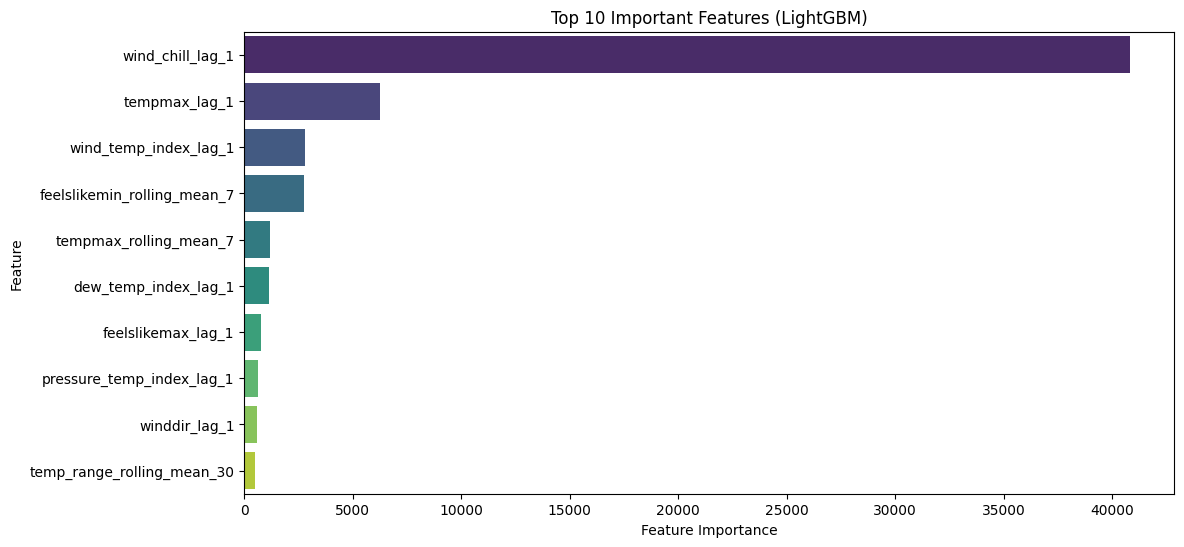

In [97]:
# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")
plt.title("Top 10 Important Features (LightGBM)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

The feature importance is computed using ```importance_type="gain"```. This means that the importance of a feature is measured by the total reduction in **Error** (loss) it contributes when used for splits in decision trees.
- Higher importance → More influential feature, as it helps reduce error the most.

`wind_chill_lag_1` has the highest importance 🡪 This suggests that wind chill from the previous day strongly influences the predicted temperature.

`tempmax_lag_1` is also highly important 🡪 This means that the maximum temperature of the previous day is crucial for predicting the next day’s temperature.

Rolling mean features (`temp_rolling_mean_7`) are significant 🡪 This indicates that long-term temperature trends play a key role in the model’s prediction.

# **Modeling**

### **1. Random Forest**
- In this notebook, we successfully trained and tuned a Random Forest Regressor model to predict temperature data.
- Using GridSearchCV to optimize hyperparameters and achieved a Mean Absolute Error (MAE) on the test set.
    ```py
    param_grid = {
        "n_estimators": [50, 100, 200, 300],  # Number of trees
        "max_depth": [5, 10, 20, None],  # Tree depth
        "min_samples_split": [2, 5, 10],  # Minimum samples to split
        "min_samples_leaf": [1, 2, 5],  # Minimum samples in a leaf
        "max_features": ["sqrt", "log2", None],  # Feature selection strategy
        "bootstrap": [True, False],  # Bootstrap sampling
    }
    ```
- The best model was saved using pickle. The best hyperparameter below:
    ```py
    best_params = {
        'bootstrap': True, 
        'max_depth': 10, 
        'max_features': None, 
        'min_samples_leaf': 1, 
        'min_samples_split': 5, 
        'n_estimators': 100
    }
    ```

[Notebook](https://www.kaggle.com/code/thnquangvinh/randomforest)

**Hyperparameter in Fine-Tuning**

- `n_estimators` controls the number of trees in the forest. More trees generally improve stability and performance, but after a certain point, the benefits diminish while computation time increases. By testing values from 50 to 300, we ensure a balance between accuracy and efficiency.

- `max_depth` determines how deep each tree can grow. Limiting depth (e.g., 5 or 10) helps prevent overfitting, while allowing deeper trees (e.g., 20 or None) enables the model to capture complex patterns. This tradeoff ensures the model generalizes well without excessive complexity.

- `min_samples_split` specifies the minimum number of samples required to split a node. A lower value (2) allows deep splits, capturing detailed relationships but increasing the risk of overfitting. Higher values (5 or 10) force the model to generalize better by reducing unnecessary splits.

- `min_samples_leaf` sets the minimum number of samples required in each leaf node. A value of 1 allows small leaves, which may lead to noise and overfitting. Increasing this to 2 or 5 helps create more stable trees, reducing variance and improving generalization.

- `max_features` determines how many features are considered when splitting a node. Using "sqrt" or "log2" helps introduce randomness, reducing correlation between trees and improving generalization. Setting it to None allows all features, which might improve accuracy but increases the risk of overfitting.

- `bootstrap` controls whether sampling is done with replacement. Enabling bootstrap (True) encourages diversity among trees, reducing overfitting and variance. Disabling it (False) may lead to faster training but can cause overfitting since each tree sees the full dataset.

In [30]:
# Open the model file
with open(r"model\random_forest_model.pkl", "rb") as file:
    model = joblib.load(file)

In [31]:
X_test = pd.read_csv(r"data\X_test.csv")
y_test = pd.read_csv(r"data\y_test.csv")
# Predict using the loaded model
X = pd.read_csv(r"data\data.csv")

y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred,index=range(351,382))

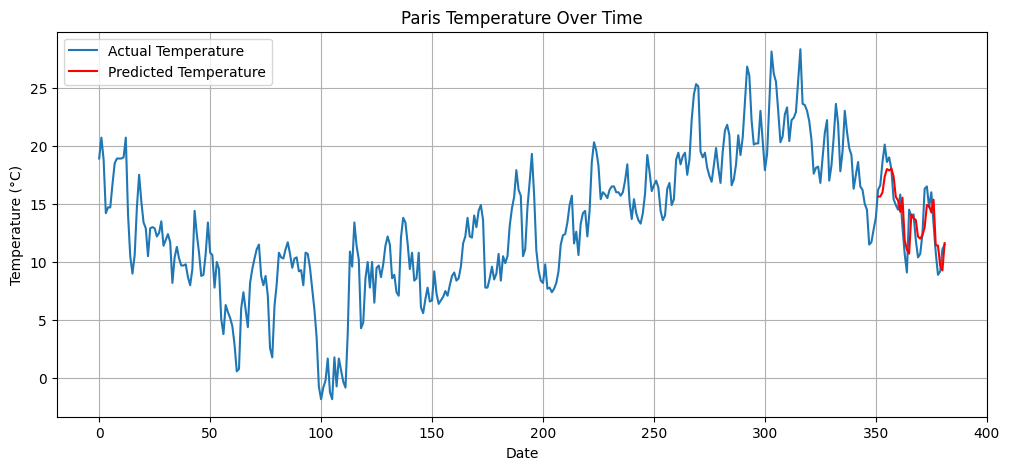

In [32]:
# Plot Paris temperature over time
plt.figure(figsize=(12, 5))
plt.plot(X["temp"], linestyle='-', label="Actual Temperature")
plt.plot(y_pred, linestyle='-', label="Predicted Temperature", color="red")
plt.title("Paris Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Evaluation
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE after tuning: {mae:.2f}")

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE after tuning: {mape:.2%}")

r2 = r2_score(y_test, y_pred)
print(f"R² after tuning: {r2:.2f}")

MAE after tuning: 1.39
MAPE after tuning: 10.32%
R² after tuning: 0.70


- Mean Absolute Error (MAE) = 1.39

    This means that, on average, the model’s predicted temperature deviates by 1.39°C from the actual temperature. -> This is a relatively low error, indicating good performance.

- R² Score = 0.70

    The R² (coefficient of determination) tells us how well the model explains the variance in the data. A value of 0.70 means the model explains 70% of the temperature variation, which is a strong result but suggests there is still room for improvement.




### **Compare with The Prophet Model**
| Metric         | Prophet Model | Random Forest Model |
|----------------|---------------|----------------------|
| **MAE**        | 4.00          | 1.39                |
| **R² Score**   | -0.68         | 0.70                |
| **MAPE**       | 21.10%        | 10.32%              |

1. **Mean Absolute Error (MAE)**:  
    - Random Forest has a significantly lower MAE (1.39°C) compared to Prophet (4.00°C), indicating that Random Forest predictions are closer to the actual values.

2. **R² Score**:  
    - Prophet has a negative R² score (-0.68), meaning it fails to capture the variance in the data.  
    - Random Forest achieves a positive R² score (0.70), explaining 70% of the variance in the temperature data.

3. **Mean Absolute Percentage Error (MAPE)**:  
    - Random Forest has a lower MAPE (10.32%) compared to Prophet (21.10%), showing better accuracy in percentage terms.

### **Conclusion**
The Random Forest model outperforms the Prophet model in all key metrics, particularly in MAE, R², and MAPE. Prophet struggles to capture short-term fluctuations and relies heavily on long-term trends, while Random Forest leverages feature interactions and historical data more effectively.

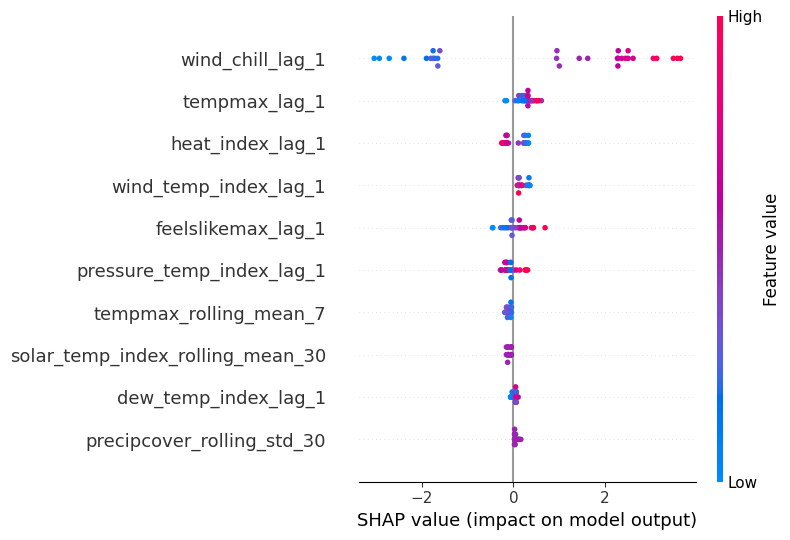

In [102]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, show=False, max_display=10)

- **Wind Chill (Lag 1) is the Most Influential Feature**

    Strongly impacts the model’s predictions, with extreme values significantly shifting temperature forecasts. Lower wind chill (blue dots) often correlates with lower temperature predictions (left shift in SHAP values).

- **Recent Maximum Temperature (Tempmax Lag 1) is a Strong Predictor**

    Yesterday’s max temperature is a crucial factor for today’s prediction.Higher past temperatures (red dots) increase the predicted temperature (right shift).

- **Heat Index and Wind-Temperature Index Play a Key Role**

    The heat index reflects how humidity influences perceived temperature.Wind-temperature index shows how wind modifies actual temperature, explaining its importance.

- **Rolling Means Capture Long-Term Trends**

    7-day and 30-day rolling features (e.g., tempmax_rolling_mean_7, solar_temp_index_rolling_mean_30) help the model smooth out fluctuations and recognize trends. These features provide trend stability, preventing the model from overreacting to daily variations.

- **Weather Interaction Features Matter**

    Pressure-Temperature Index & Dew Temp Index show how pressure and moisture interact with temperature. Precipitation Cover Rolling Std (30 Days) suggests that unstable weather conditions influence temperature trends.

### **2. LightGBM**

[Notebook](https://www.kaggle.com/code/tronnt/lgbm-modeling)

In [103]:
# Open the LightGBM model file
with open(r"model\light_gbm_model.pkl", "rb") as file:
    model_lightGBM = joblib.load(file)

In [104]:
y_pred_ = model_lightGBM.predict(X_test)
y_pred_ = pd.Series(y_pred,index=range(351,382))

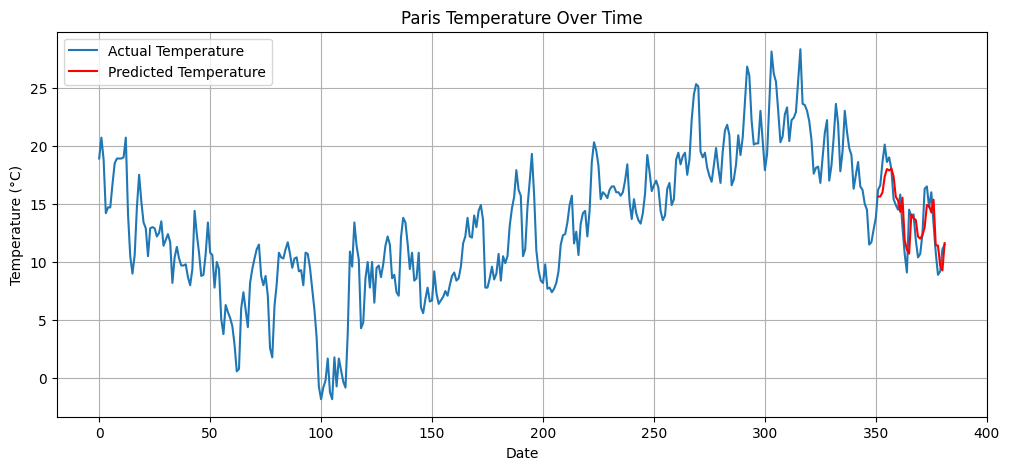

In [105]:
# Plot Paris temperature over time
plt.figure(figsize=(12, 5))
plt.plot(X["temp"], linestyle='-', label="Actual Temperature")
plt.plot(y_pred_, linestyle='-', label="Predicted Temperature", color="red")
plt.title("Paris Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

In [106]:
mae = mean_absolute_error(y_test, y_pred_)
print(f"MAE after tuning: {mae:.2f}")

r2 = r2_score(y_test, y_pred_)
print(f"R² after tuning: {r2:.2f}")

MAE after tuning: 1.39
R² after tuning: 0.70


# **Weekly averaging temperatures**

In [4]:
X_train = pd.read_csv(r"data\X_train.csv")
y_train = pd.read_csv(r"data\y_train.csv")
X_test = pd.read_csv(r"data\X_test.csv")
y_test = pd.read_csv(r"data\y_test.csv")

In [19]:
def to_weekly(df, start_date):
    df.index = pd.date_range(start="2023-10-01", periods=len(df), freq="D")
    df_weekly = df.resample("W").mean()
    df_weekly = df_weekly.reset_index()
    df_weekly.drop(columns=["index"], inplace=True)
    return df_weekly

In [20]:
X_train_weekly, y_train_weekly = to_weekly(X_train, "2023-10-01"), to_weekly(y_train, "2023-10-01")
X_test_weekly, y_test_weekly = to_weekly(X_test, "2024-09-16"), to_weekly(y_test, "2024-09-16")

In [22]:
X_train_weekly.to_csv(r"data\X_train_weekly.csv", index=False)
y_train_weekly.to_csv(r"data\y_train_weekly.csv", index=False)
X_test_weekly.to_csv(r"data\X_test_weekly.csv", index=False)
y_test_weekly.to_csv(r"data\y_test_weekly.csv", index=False)

### **1. Random Forest**
[Notebook](https://www.kaggle.com/code/thnquangvinh/weekly-rf)

In [34]:
# Open the LightGBM model file
with open(r"model/random_forest_model(weekly).pkl", "rb") as file:
    model_RF_w = joblib.load(file)

In [35]:
y_pred = model_RF_w.predict(X_test_weekly)

In [36]:
# Evaluation
mae = mean_absolute_error(y_test_weekly, y_pred)
print(f"MAE after tuning: {mae:.2f}")

mape = mean_absolute_percentage_error(y_test_weekly, y_pred)
print(f"MAPE after tuning: {mape:.2%}")

r2 = r2_score(y_test_weekly, y_pred)
print(f"R² after tuning: {r2:.2f}")

MAE after tuning: 0.75
MAPE after tuning: 5.87%
R² after tuning: 0.85


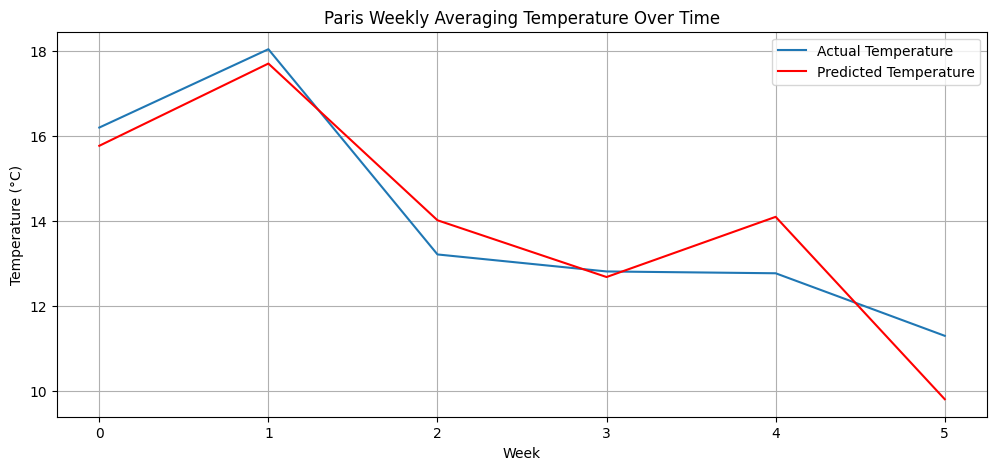

In [37]:
# Plot Paris temperature over time
plt.figure(figsize=(12, 5))
plt.plot(y_test_weekly, linestyle='-', label="Actual Temperature")
plt.plot(y_pred, linestyle='-', label="Predicted Temperature", color="red")
plt.title("Paris Weekly Averaging Temperature Over Time")
plt.xlabel("Week")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

#### **1. Performance Metrics**
| Metric         | Daily Model       | Weekly Model       |
|----------------|-------------------|--------------------|
| **MAE**        | 1.39              | 0.75              |
| **MAPE**       | 10.32%            | 5.87%             |
| **R² Score**   | 0.70              | 0.85              |

- **MAE (Mean Absolute Error)**:  
    - The weekly model achieves a lower MAE (0.75°C) compared to the daily model (1.39°C), indicating that the weekly model has better accuracy in absolute terms.

- **MAPE (Mean Absolute Percentage Error)**:  
    - The weekly model has a significantly lower MAPE (5.87%) compared to the daily model (10.32%), showing that the weekly model is more accurate in percentage terms.

- **R² Score**:  
    - The weekly model achieves a higher R² score (0.85) compared to the daily model (0.70), meaning it explains more variance in the data and better captures the underlying trends.

#### **2. Data Granularity**
- **Daily Model**:  
    - The daily model predicts temperature on a day-to-day basis, which introduces more noise and variability due to short-term fluctuations in weather conditions.
    - This makes it harder for the model to achieve high accuracy, as daily temperature can be influenced by sudden, unpredictable factors.

- **Weekly Model**:  
    - The weekly model predicts average temperatures over a week, which smooths out daily fluctuations and reduces noise.
    - This allows the model to focus on long-term trends, leading to better performance metrics.

#### **3. Use Case**
- **Daily Model**:  
    - Suitable for applications requiring high-resolution, short-term forecasts, such as daily weather predictions or event planning.
    - However, it may struggle with accuracy due to the inherent variability in daily data.

- **Weekly Model**:  
    - Ideal for long-term planning or trend analysis, such as seasonal forecasting or agricultural planning.
    - The weekly model sacrifices granularity for improved accuracy and stability.

#### **4. Model Complexity**
- Both models use Random Forest, but the weekly model benefits from reduced data variability, making it easier for the model to learn patterns and relationships.

#### **Conclusion**
The weekly Random Forest model outperforms the daily model in all key metrics (MAE, MAPE, R²). While the daily model provides higher granularity, it is more prone to noise and variability. The choice between the two depends on the specific use case: daily predictions for short-term needs and weekly predictions for long-term trends and planning.